In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception, VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 필수 : 런타임 -> 런타임 유형변경 -> GPU

In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=d58e393943a5dbe33c9d980ac183fd726c86a0e63dc5a18f5148fa9cb9b2c094
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [3]:
'''
cats_and_dogs_filtered 데이터셋은 25,000개의 이미지를 포함하는 원본 Dogs Vs. Cats 데이터셋에서 약 3,000개의 이미지를 추출한 간소화된 버전의 데이터셋입니다.

'''
import wget

url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
wget.download(url) # 현재 폴더에 파일 다운로드

'cats_and_dogs_filtered.zip'

In [4]:
# 현재 폴더에 파일이 있는지 확인
!dir cat*.zip

cats_and_dogs_filtered.zip


In [5]:
import os
base_path="./content/cats_and_dogs_filtered/"
os.path.exists(base_path)  # 작업 디렉토리는 cats_and_dogs_filtered

False

In [6]:
import os
import shutil

if os.path.exists(base_path):    #작업디렉토리가 존재하면 내용을 삭제함
    
    shutil.rmtree(base_path)
    print(base_path,'  is removed !!!')
else:
    os.makedirs(base_path)    #작업디렉토리가 없으면 생성함
    print(base_path,' is MAKED !!!')

./content/cats_and_dogs_filtered/  is MAKED !!!


In [7]:
# 압축파일 풀기

import zipfile
#현재디렉토리에 있는 cats_and_dogs_filtered.zip 을 작업 디렉토리에 압축해제한다
with zipfile.ZipFile('./cats_and_dogs_filtered.zip', 'r') as target_file: 

    target_file.extractall(base_path)  # ./content/cats_and_dogs_filtered/

In [8]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [9]:
base_model = VGG16(weights='imagenet', 
                   include_top=False, # 기존 출력층(10개분류) 안쓰고 내가 정하는 분류층을 정의할 예정
                   input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

base_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [10]:
# 처리층 정의
model = Sequential()

model.add(base_model) # 기존층 추가

model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax')) #최종출력은  2개, [0일 확률 1일 확률] 형태로 반환

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 16)                401424    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 15,116,146
Trainable params: 15,116,146
Non-trainable params: 0
_________________________________________________________________


In [11]:
print('base_model를 동결 전 학습 가중치 변수 층 수:', 
      len(model.trainable_weights)) 

base_model를 동결 전 학습 가중치 변수 층 수: 30


In [12]:
base_model.trainable = False # 기존 파라미터 학습 수정 안함.

In [13]:
print('conv_base를 동결 후 학습 가중치 변수 층 수:', 
      len(model.trainable_weights)) # 학습할 층 갯수 출력

conv_base를 동결 후 학습 가중치 변수 층 수: 4


In [14]:
# ImageDataGenerator 이용하여 데이터 불러옴

train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=10, 
                                    width_shift_range=0.1, 
                                    height_shift_range=0.1, 
                                    shear_range=0.1, 
                                    zoom_range=0.1)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [15]:
train_dir = './content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'

test_dir = './content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

class_mode='categorical' 이면 정답은 one-hot encoding 됨.  
class_mode='binary' 이면 정답은 0,1 됨.  
class_mode='softmax' 이면 정답은 여러개의 확률이 반환됨.

In [16]:
train_data = train_data_gen.flow_from_directory(train_dir, batch_size=32, 
                                                color_mode='rgb', 
                                                shuffle=True, 
                                                class_mode='categorical',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


test_data = test_data_gen.flow_from_directory(test_dir, batch_size=32, 
                                              color_mode='rgb', 
                                              shuffle=True, 
                                              class_mode='categorical',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
# 정답 확인

print(train_data.class_indices.items())
print(test_data.class_indices.items())

print(len(train_data.classes))
print(len(test_data.classes))

print(train_data.num_classes)
print(test_data.num_classes)

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])
2000
1000
2
2


In [18]:
# 모델 컴파일

# model.compile(loss='categorical_crossentropy', 
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [19]:
train_data.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [20]:
train_data.num_classes

2

In [21]:
train_data.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [23]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_VGG16_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,       
                             monitor='val_loss',   
                             verbose=1,            
                             save_best_only=True,  # val_loss가 가장 낮을때마다 저장
                             mode='auto'           
                            )

earlystopping = EarlyStopping(monitor='val_loss',  
                              patience=5,          
                             )

start_time = datetime.now()

hist = model.fit(train_data, 
                #  epochs=30, 
                 epochs=10, 
                 validation_data=test_data,
                 callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.6245
Epoch 1: val_loss improved from inf to 0.59249, saving model to ./cats_and_dogs_filtered_VGG16_Colab.h5
63/63 [==============================] - 51s 577ms/step - loss: 0.6537 - accuracy: 0.6245 - val_loss: 0.5925 - val_accuracy: 0.7380
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.5810 - accuracy: 0.7360
Epoch 2: val_loss improved from 0.59249 to 0.52040, saving model to ./cats_and_dogs_filtered_VGG16_Colab.h5
63/63 [==============================] - 32s 501ms/step - loss: 0.5810 - accuracy: 0.7360 - val_loss: 0.5204 - val_accuracy: 0.8140
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.7850
Epoch 3: val_loss improved from 0.52040 to 0.46702, saving model to ./cats_and_dogs_filtered_VGG16_Colab.h5
63/63 [==============================] - 33s 526ms/step - loss: 0.5271 - accuracy: 0.7850 - val_loss: 0.4670 - val_accuracy: 0.8360
Ep

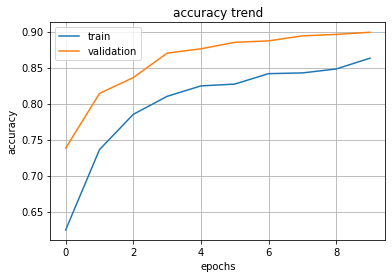

In [24]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

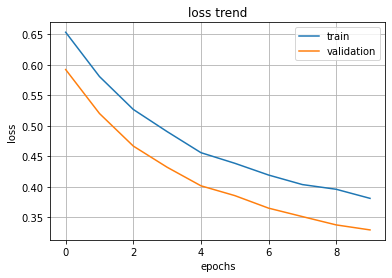

In [25]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

In [26]:
import os
import shutil

if os.path.exists('./content/test_image_dir/'):    
    
    shutil.rmtree('./content/test_image_dir/')
    print('./content/test_image_dir/  is removed !!!')
else:
    os.makedirs('./content/test_image_dir/')
    print('./content/test_image_dir/  is MAKED !!!')    

./content/test_image_dir/  is MAKED !!!


In [27]:
# 압축파일 풀기 - 테스트용 고양이,강아지 이미지는 직접 다운로드해야함.

import zipfile

# with zipfile.ZipFile('./content/test_image_dir.zip', 'r') as target_file:
with zipfile.ZipFile('./test_image_dir.zip', 'r') as target_file:

    target_file.extractall('./content/test_image_dir/') 

In [28]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('./content/test_image_dir/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['./content/test_image_dir/cat.4002.jpg', './content/test_image_dir/dog.4002.jpg', './content/test_image_dir/dog.4003.jpg', './content/test_image_dir/cat.4001.jpg', './content/test_image_dir/cat.4003.jpg', './content/test_image_dir/dog.4001.jpg']
6


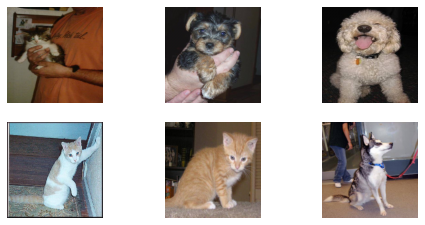

In [29]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):

    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [30]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


In [31]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(6, 224, 224, 3)


In [32]:
# predict 실행

class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

(6, 2)
[[0.13755672 0.86244327]
 [0.01243422 0.9875658 ]
 [0.0459382  0.95406175]
 [0.8057237  0.19427632]
 [0.93381256 0.06618746]
 [0.2649766  0.7350234 ]]


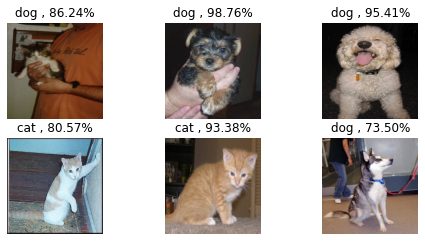

In [33]:
class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

plt.figure(figsize=(8,6))

for i in range(len(pred)):

    plt.subplot(3, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()